In [1]:
import pathlib
import warnings
import warnings
warnings.filterwarnings('ignore')
import os

import sys
sys.path.append('../code/')
import pm_model_func as pmf

# Third-party
import astropy.coordinates as coord
import astropy.table as at
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy.lib.recfunctions import stack_arrays
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from pyia import GaiaData
from scipy.stats import binned_statistic

import arviz as az
import pymc3 as pm
import seaborn as sns
from tqdm import trange
from pymc3 import *
import theano.tensor as tt
import pymc3_ext as pmx
from patsy import dmatrix

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.4


In [18]:
def plot_pretty(dpi=175, fontsize=15, labelsize=15, figsize=(10, 8), tex=True):
    # import pyplot and set some parameters to make plots prettier
    plt.rc('savefig', dpi=dpi)
    plt.rc('text', usetex=tex)
    plt.rc('font', size=fontsize)
    plt.rc('xtick.major', pad=1)
    plt.rc('xtick.minor', pad=1)
    plt.rc('ytick.major', pad=1)
    plt.rc('ytick.minor', pad=1)
    plt.rc('figure', figsize=figsize)
    mpl.rcParams['xtick.labelsize'] = labelsize
    mpl.rcParams['ytick.labelsize'] = labelsize
    mpl.rcParams.update({'figure.autolayout': False})
    
plot_pretty(fontsize=20, labelsize=20)

In [3]:
import importlib
importlib.reload(pmf)

gaia = GaiaData('../data/gd1_ps1_with_basic_masks_thin.fits')
#gaia = GaiaData('../data/gd1_pass_cuts.fits')

stream_mask = gaia.gi_cmd_mask
g = gaia[(stream_mask)]# & (gaia.g_0 < 18)]
#g = gaia

dist = g.get_distance(min_parallax=1e-3*u.mas)
c = g.get_skycoord(distance=dist)
stream_coord = c.transform_to(gc.GD1)
phi1 = stream_coord.phi1.degree
phi2 = stream_coord.phi2.degree
pm1 = stream_coord.pm_phi1_cosphi2
pm2 = stream_coord.pm_phi2

after = GaiaData('../data/sorted_pm_member_prob_all_stars_8comp.fits')
after_all = GaiaData('../data/member_prob_all.fits')

g_sorted, obs_pm_all, obs_pm_cov_all, phi1_stream_all, phi2_stream_all, bkg_ind = pmf.pre_model(gaia, g, after)
ln_bg_prob_all = after.pm_ln_bkg_prob.astype('float64')
ln_bg_prob = ln_bg_prob_all[bkg_ind]

## THE FULL MODEL Including the Spur

In [19]:
import importlib
importlib.reload(pmf)

with pm.Model() as model:
    n_pm_nodes, n_track_nodes, n_width_nodes = 11, 8, 5
    
    # mixture weight
    alpha = pm.Uniform('alpha', lower = 0, upper = 1, testval=5e-4)
    beta = pm.Uniform('beta', lower=0, upper = 1, testval=0.3)

    loglike_fg_pm, loglike_fg_pm_all = pmf.pm_model_spline(model, obs_pm_all, obs_pm_cov_all, 
                                                           phi1_stream_all, bkg_ind, n_pm_nodes)
    ll_fg_pm = pm.Deterministic('ll_fg_pm', tt.log(alpha) + loglike_fg_pm)
    ll_fg_pm_all = pm.Deterministic('ll_fg_pm_all', tt.log(alpha) + loglike_fg_pm_all)
    
    loglike_fg_phi2, loglike_fg_phi2_all = pmf.phi2_model_spline(model, phi1_stream_all, phi2_stream_all, bkg_ind,
                                                                 n_track_nodes, n_width_nodes)
    loglike_fg_phi2_all = loglike_fg_phi2_all.reshape(loglike_fg_pm_all.shape)
    loglike_fg_phi2 = loglike_fg_phi2.reshape(loglike_fg_pm.shape)
    ll_fg_phi2_all = pm.Deterministic('ll_fg_phi2_all', tt.log(beta) + loglike_fg_phi2_all)
    ll_fg_phi2 = pm.Deterministic('ll_fg_phi2', tt.log(beta) + loglike_fg_phi2)
    
    loglike_fg_spur, loglike_fg_spur_all = pmf.spur_model(model, phi1_stream_all, phi2_stream_all, bkg_ind)
    loglike_fg_spur_all = loglike_fg_spur_all.reshape(loglike_fg_pm_all.shape)
    loglike_fg_spur = loglike_fg_spur.reshape(loglike_fg_pm.shape)
    ll_fg_phi2_spur_all = pm.Deterministic('ll_fg_phi2_spur_all', 
                                           tt.log(alpha) + tt.log(1-beta) + loglike_fg_spur_all)
    ll_fg_phi2_spur = pm.Deterministic('ll_fg_phi2_spur', tt.log(alpha) + tt.log(1-beta) + loglike_fg_spur)
    
    #total track likelihood (including spur)
    loglike_fg_phi2_total_all = pm.Deterministic('ll_fg_phi2_total_all', 
                                                 pm.logaddexp(loglike_fg_phi2_all, loglike_fg_spur_all))
    loglike_fg_phi2_total = pm.Deterministic('ll_fg_phi2_total', pm.logaddexp(loglike_fg_phi2, loglike_fg_spur))
    
    #total foreground likelihood
    loglike_fg_all = loglike_fg_pm_all + loglike_fg_phi2_total_all
    loglike_fg = loglike_fg_pm + loglike_fg_phi2_total
    ll_fg_full_all = pm.Deterministic('ll_fg_full_all', tt.log(alpha) + loglike_fg_all)
    ll_fg_full = pm.Deterministic('ll_fg_full', tt.log(alpha) + loglike_fg)
    
    ll_bg_full_all = pm.Deterministic('ll_bg_full_all', tt.log(1 - alpha) + ln_bg_prob_all)
    ll_bg_full = pm.Deterministic('ll_bg_full', tt.log(1 - alpha) + ln_bg_prob)

    loglike = pm.logaddexp(ll_fg_full, ll_bg_full)
    pm.Potential("loglike", loglike)

In [ ]:
with model:
    res, logp = pmx.optimize(start={'b4': 0.3,
                                'ln_std_phi2_spur': np.log(0.1),
                                'beta': 0.3}, 
                             return_info = True)

optimizing logp for variables: [ln_std_phi2_spur, spur_track_scale, width_nodes, track_nodes, ln_std_pm_stream, pm_nodes, beta, alpha]


In [ ]:
post_member_prob3 = np.exp(
            res['ll_fg_full'] 
            - np.logaddexp(res['ll_fg_full'], res['ll_bg_full']))

post_member_prob3_pm = np.exp(
            res['ll_fg_pm'] 
            - np.logaddexp(res['ll_fg_pm'], res['ll_bg_full']))

post_member_prob3_phi2 = np.exp(
            res['ll_fg_phi2_total'] 
            - np.logaddexp(res['ll_fg_phi2_total'], res['ll_bg_full']))


post_member_prob3_all = np.exp(
            res['ll_fg_full_all'] 
            - np.logaddexp(res['ll_fg_full_all'], res['ll_bg_full_all']))

post_member_prob3_pm_all = np.exp(
            res['ll_fg_pm_all'] 
            - np.logaddexp(res['ll_fg_pm_all'], res['ll_bg_full_all']))

post_member_prob3_phi2_all = np.exp(
            res['ll_fg_phi2_total_all'] 
            - np.logaddexp(res['ll_fg_phi2_total_all'], res['ll_bg_full_all']))

print('# among selected stars with total membership probability > 0.1: {}'.format((post_member_prob3 > 0.1).sum()))
print('# among selected stars with PM membership probability > 0.1: {}'.format((post_member_prob3_pm > 0.1).sum()))
print('# among selected stars with track membership probability > 0.1: {}'.format((post_member_prob3_phi2 > 0.1).sum()))
print('-------------------------------------------')
print('# among all stars with total membership probability > 0.1: {}'.format((post_member_prob3_all > 0.1).sum()))
print('# among all stars with PM membership probability > 0.1: {}'.format((post_member_prob3_pm_all > 0.1).sum()))
print('# among all stars with track membership probability > 0.1: {}'.format((post_member_prob3_phi2_all > 0.1).sum()))

In [ ]:
tbl = at.Table()
tbl['phi1'] = phi1_stream_all
tbl['phi2'] = phi2_stream_all
tbl['g_0'] = g_sorted.g_0
tbl['i_0'] = g_sorted.i_0
tbl['pm1'] = obs_pm_all[:,0]
tbl['pm2'] = obs_pm_all[:,1]
tbl['pm_cov'] = obs_pm_cov_all
tbl['ln_bg_prob'] = ln_bg_prob_all
tbl['post_member_prob'] = post_member_prob3_all
tbl['post_member_prob_pm'] = post_member_prob3_pm_all
tbl['post_member_prob_phi2'] = post_member_prob3_phi2_all

tbl.write('../data/member_prob_3_all.fits', overwrite=True)

tbl = at.Table()
tbl['phi1'] = phi1_stream_all[bkg_ind]
tbl['phi2'] = phi2_stream_all[bkg_ind]
tbl['g_0'] = g_sorted.g_0[bkg_ind]
tbl['i_0'] = g_sorted.i_0[bkg_ind]
tbl['pm1'] = obs_pm_all[:,0][bkg_ind]
tbl['pm2'] = obs_pm_all[:,1][bkg_ind]
tbl['pm_cov'] = obs_pm_cov_all[bkg_ind]
tbl['ln_bg_prob'] = ln_bg_prob_all[bkg_ind]
tbl['post_member_prob'] = post_member_prob3
tbl['post_member_prob_pm'] = post_member_prob3_pm
tbl['post_member_prob_phi2'] = post_member_prob3_phi2

tbl.write('../data/member_prob_3.fits', overwrite=True)

In [ ]:
# QUESTION: when plotting, do we want to use just one cut on the total memb prob or do we want to say 
##           memb_prob_pm > 0.6 OR memb_prob_phi2>0.8
after3 = GaiaData('../data/member_prob_3_all.fits')

high_memb_prob3_pm = after3[after3.post_member_prob_pm > 0.3]
high_memb_prob3_phi2 = after3[after3.post_member_prob_phi2 > 0.3]
high_memb_prob3_OR = after3[(after3.post_member_prob > 0.3)]

plt.figure(figsize=(18,3))
plt.scatter(high_memb_prob3_pm.phi1, high_memb_prob3_pm.phi2, c = high_memb_prob3_pm.post_member_prob_pm,
            s = 5, cmap='plasma_r', vmax = 1)
plt.colorbar()
plt.xlim(-100, 20); plt.ylim(-10, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Proper Motion Memb Prob')

plt.figure(figsize=(18,3))
plt.scatter(high_memb_prob3_phi2.phi1, high_memb_prob3_phi2.phi2, c=high_memb_prob3_phi2.post_member_prob_phi2, 
            s = 5, cmap='plasma_r', vmin=0.5, vmax=1)
plt.colorbar()
plt.xlim(-100, 20); plt.ylim(-10, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Phi2 Membership Probability')

plt.figure(figsize=(18,3))
plt.scatter(high_memb_prob3_OR.phi1, high_memb_prob3_OR.phi2, c = high_memb_prob3_OR.post_member_prob, 
            s = 5, cmap='plasma_r', vmax=1)
plt.colorbar()
plt.xlim(-100, 20); plt.ylim(-6, 3); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Membership Probabilities Combined')

plt.figure(figsize=(6,8))
plt.scatter(high_memb_prob3_OR.g_0 - high_memb_prob3_OR.i_0, high_memb_prob3_OR.g_0,  
            c = high_memb_prob3_OR.post_member_prob, s = 5, cmap='plasma_r', vmax=1)
plt.colorbar()
plt.xlim(-0.25, 1.5)
plt.ylim(21, 16)
#plt.savefig('../memb_probabilities_stream_with_spur.jpg')

In [ ]:
phi1_stream = phi1_stream_all[bkg_ind]
plt.figure(figsize = (14,5))
plt.plot(phi1_stream, res['std_phi2_stream'])
plt.title(r'Width of Stream')
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'Width [deg]')
plt.xlim(-100, 20); plt.ylim(0,0.5)
plt.grid()

plt.figure(figsize = (14,2))
plt.fill_between(phi1_stream[:,0], res['mean_phi2_stream']+ res['std_phi2_stream'],
                              res['mean_phi2_stream']- res['std_phi2_stream'], color='r',alpha=0.5)
plt.title(r'Track of Stream with Width')
plt.scatter(high_memb_prob3_OR.phi1, high_memb_prob3_OR.phi2, s = 4)
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.xlim(-100, 20); plt.ylim(-6,2)
plt.grid()

plt.figure(figsize = (14,2))
plt.plot(phi1_stream, res['mean_pm_stream'][:,0])
plt.scatter(high_memb_prob3_OR.phi1, high_memb_prob3_OR.pm1, s = 4)
plt.title(r'PM1 Along Stream')
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\mu_{\phi_1}$ [deg]')
plt.xlim(-100, 20); plt.ylim(-15,0)

plt.figure(figsize = (14,2))
plt.plot(phi1_stream, res['mean_pm_stream'][:,1])
plt.scatter(high_memb_prob3_OR.phi1, high_memb_prob3_OR.pm2, s = 4)
plt.title(r'PM2 along Stream')
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\mu_{\phi_2}$ [deg]')
plt.xlim(-100, 20); plt.ylim(-5,0)

In [ ]:
from scipy.interpolate import UnivariateSpline
sections = np.arange(-100,15,5)
dm = np.concatenate([[14.7, 14.7, 14.6, 14.55, 14.5, 14.45, 14.4, 14.4], 
                     np.linspace(14.4, 14.9, 12), 
                     [15, 15.2, 15.4]])

plt.plot(sections, dm)
spline_dm = UnivariateSpline(sections, dm, k=5)
plt.plot(phi1_stream_all, spline_dm(phi1_stream_all))
plt.xlim(-100, 20)
plt.ylim(15.5, 14)
plt.xlabel(r'$\phi_1$')
plt.ylabel('Distance Modulus')
plt.title('Approximate Distance Modulus')

In [ ]:
plt.figure(figsize=(6,8))
after_phi1 = high_memb_prob3_OR.phi1.reshape(high_memb_prob3_OR.g_0.shape)
plt.scatter(high_memb_prob3_OR.g_0 - high_memb_prob3_OR.i_0, high_memb_prob3_OR.g_0 - spline_dm(after_phi1),  
            s = 5, c= 'k', alpha = 0.5)
plt.ylim(7, 0)
plt.xlim(-0.5, 1.2)

## Mass/Luminosity Function

In [451]:
df = pd.read_csv('../data/isochrones/MIST_iso_4D_df.csv', index_col=['feh', 'age', 'EEP'])
df_array = df.to_xarray().to_array()
m_init = df_array.loc['m_init', -1.5, 12.4, 255:600]
gmag = df_array.loc['gmag', -1.5, 12.4, 255:600]

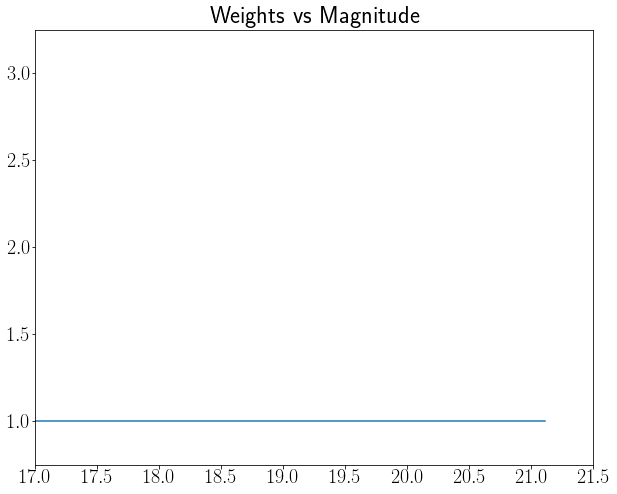

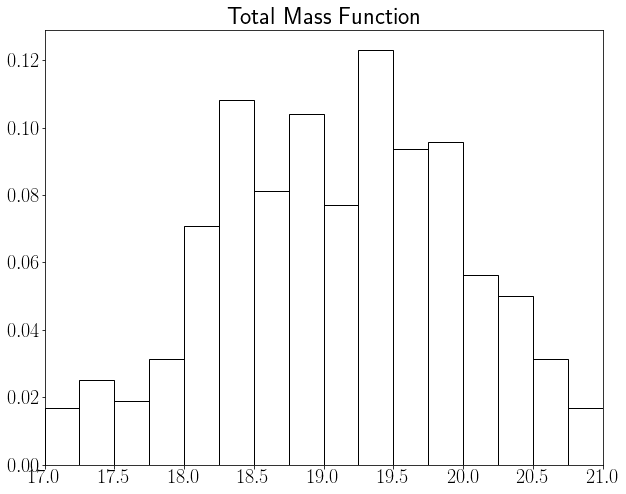

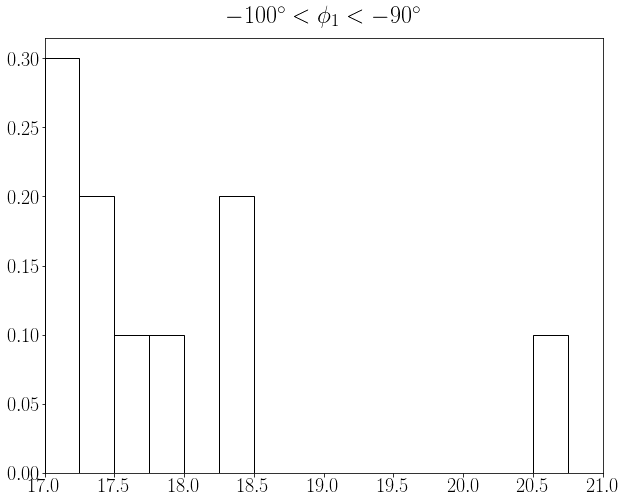

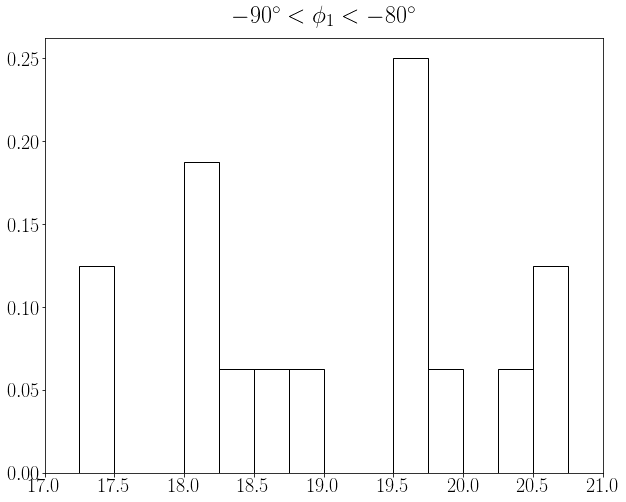

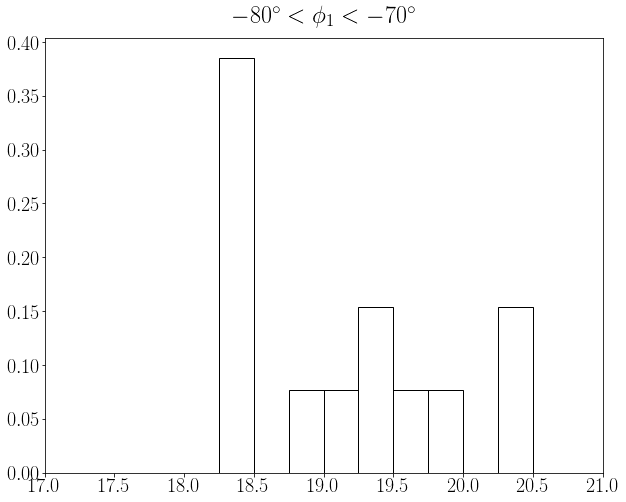

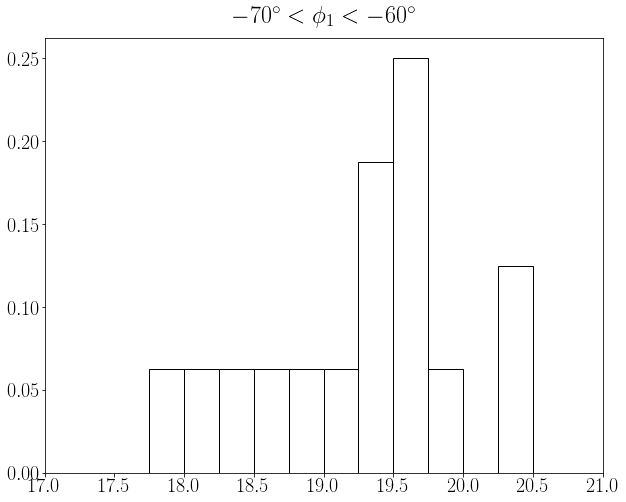

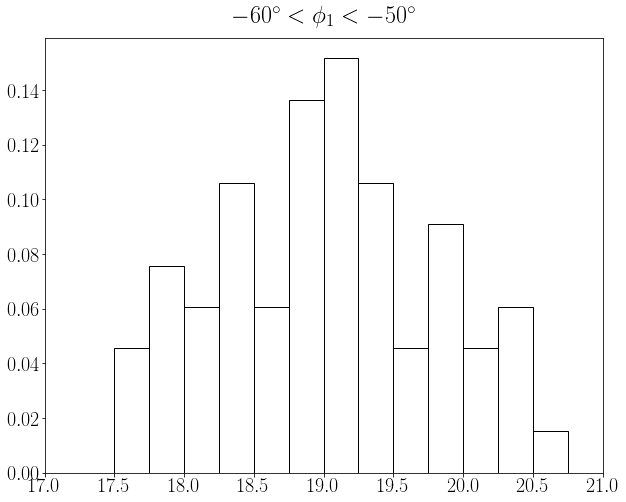

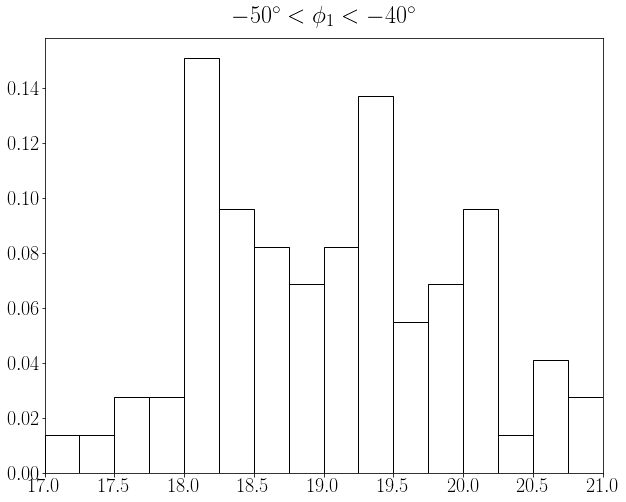

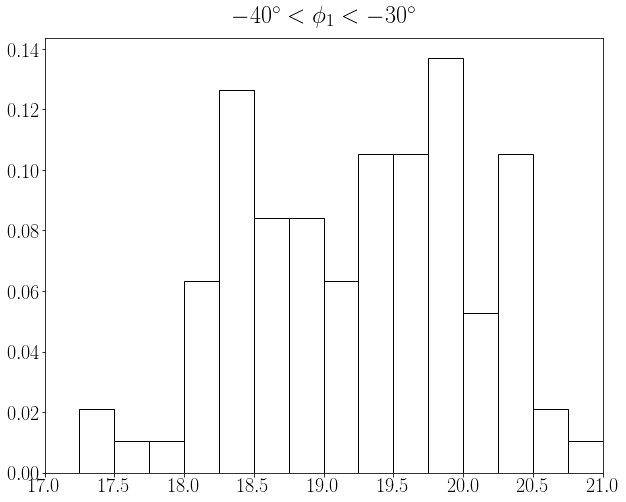

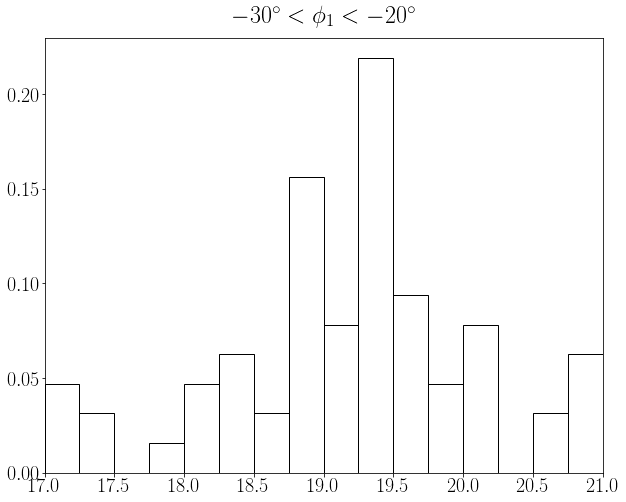

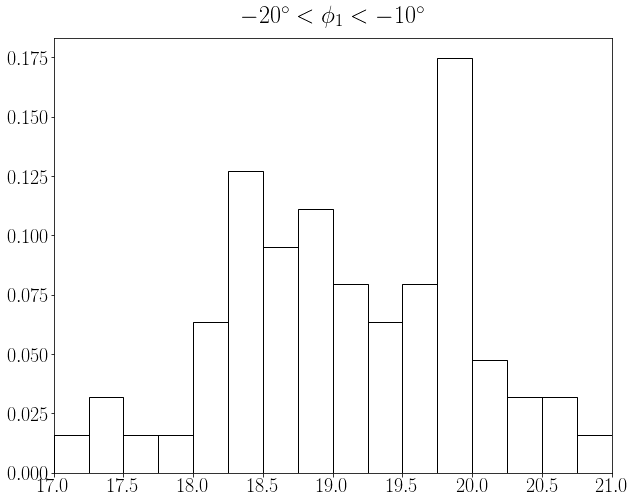

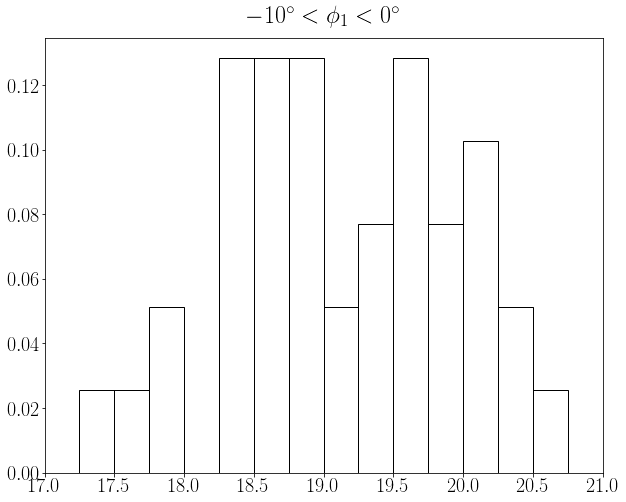

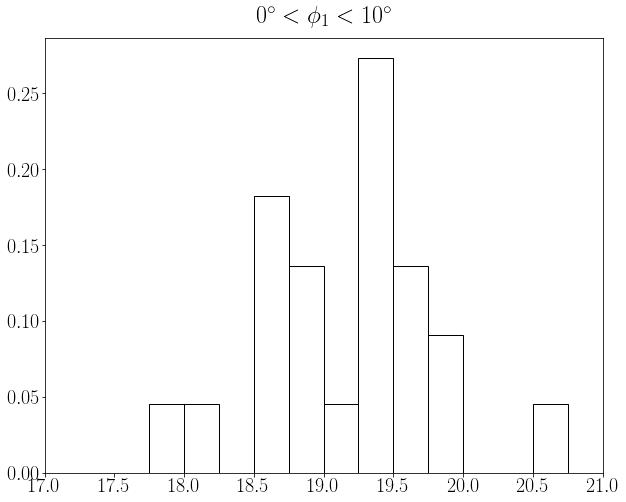

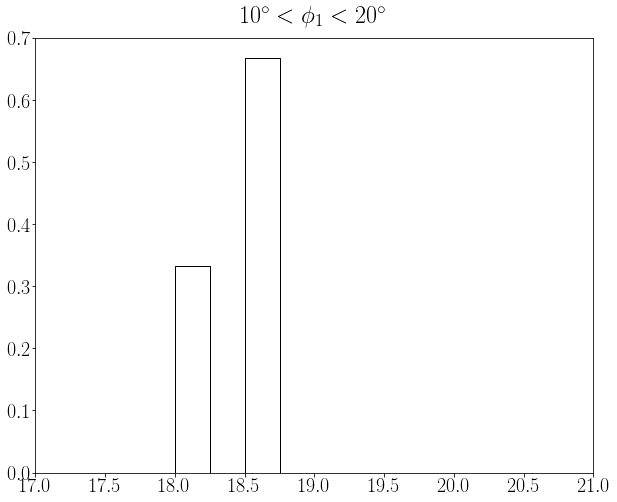

In [454]:
weights_all = np.concatenate([np.repeat(1, 650), np.linspace(1, 3, 130), np.repeat(1, 8)])
weights_all = np.ones_like(high_memb_prob3_OR.g_0)
# approx selection func from Fig 5, Fig 7 and Sec 4.1.1 of https://arxiv.org/pdf/2012.02061.pdf (Gaia EDR3)

g1 = high_memb_prob3_OR
gsort = g1[np.argsort(g1.g_0)]

plt.figure()
plt.plot(gsort.g_0, weights_all)
plt.xlim(17, 21.5)
plt.ylim(0.75, 3.25)
plt.title('Weights vs Magnitude')

plt.figure()
plt.xlim(17, 21)
counts, bins_ = np.histogram(gsort.g_0, range=[17,21], bins=16, density=True,weights = weights_all)
plt.bar(bins_[1:]-0.125, counts/4, width = 0.25, fill=False)
plt.title('Total Mass Function')
plt.xlim(17, 21)

for i in np.arange(-100, 20, 10):
    cut = (gsort.phi1.reshape(len(high_memb_prob3_OR))>i) & (gsort.phi1.reshape(len(high_memb_prob3_OR))<(i+10))
    new_gsort = gsort[cut]
    weights = weights_all[cut]
    #print(weights)
    plt.figure()
    #counts, bins_ = np.histogram(new_gsort.g_0, range=[17,21], bins=16, density=True)#,weights = weights)
    #plt.bar(bins_[:-1]-0.125, counts/4, width = 0.25, fill=False)
    plt.title(r'${}^\circ < \phi_1 < {}^\circ $'.format(i, i+10), y=1.02)
    plt.xlim(17, 21)
    #plt.figure()
    counts, bins_ = np.histogram(new_gsort.g_0, range=[17,21], bins=16, density=True,weights = weights)
    plt.bar(bins_[1:]-0.125, counts/4, width = 0.25, fill=False)
    plt.show()

622833
1091


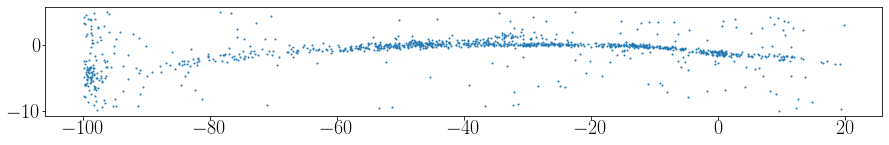

In [439]:
print(len(after3))
ad = g_sorted[((after3.post_member_prob_phi2 > 0.8) & (after3.post_member_prob_pm > 1e-2)) | 
              (after3.post_member_prob_pm > 1e-1)]
plt.figure(figsize=(15,2))
plt.scatter(ad.phi1, ad.phi2, s=1)
print(len(ad))

#final_t = ad.data
#final_t.write('../data/gd1_ps1_post_pm_model.fits', overwrite=True)

In [69]:
#for the pymc3 cmd model
np.save('../data/phi1_stream_from_pm_model.npy', phi1_stream)
np.save('../data/true_pm1_from_model.npy', res['mean_pm_stream'][:,0])
np.save('../data/true_pm2_from_model.npy', res['mean_pm_stream'][:,1])

# Earlier Versions: This probably won't work anymore
## Build the model without binning

We make the mean proper motions a function of phi1.

In [212]:
with pm.Model() as model:
    n_pm_nodes = 6
    # mixture weight
    alpha = pm.Uniform('alpha', lower = 0, upper = 1, testval=1e-4)
    
    loglike_fg = pmf.pm_model_spline(model, obs_pm, obs_pm_cov, phi1_stream, n_pm_nodes)
    
    ll_fg_full = pm.Deterministic('ll_fg_full', tt.log(alpha) + loglike_fg)
    ll_bg_full = pm.Deterministic('ll_bg_full', tt.log(1 - alpha) + ln_bg_prob)

    loglike = pm.logaddexp(ll_fg_full, ll_bg_full)
    pm.Potential("loglike", loglike)

In [11]:
with model:
    res = pmx.optimize()

optimizing logp for variables: [ln_std_pm_stream, pm_nodes, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: -2612373.2074339264 -> -2611986.094718356


722 622833


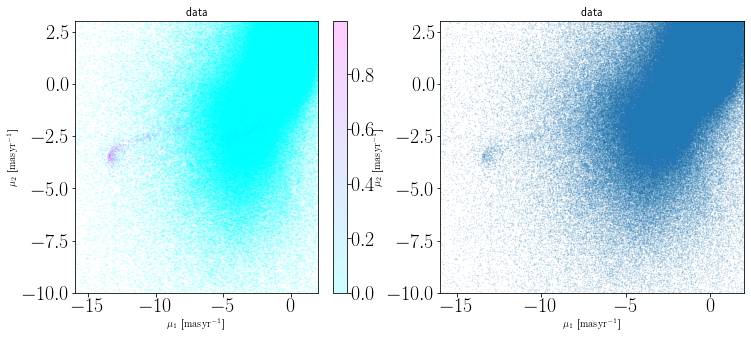

In [12]:
post_member_prob1 = np.exp(res['ll_fg_full'] - np.logaddexp(res['ll_fg_full'], res['ll_bg_full']))
print((post_member_prob1 > 0.3).sum(), len(post_member_prob1))

pmf.plot_pm_memb_prob(obs_pm, post_member_prob1)

In [13]:
tbl = at.Table()
tbl['phi1'] = phi1_stream
tbl['phi2'] = phi2_stream
tbl['pm1'] = obs_pm[:,0]
tbl['pm2'] = obs_pm[:,1]
tbl['pm_cov'] = obs_pm_cov
tbl['ln_bg_prob'] = ln_bg_prob
tbl['post_member_prob'] = post_member_prob1

tbl.write('../data/member_prob_1.fits', overwrite=True)

Text(0.5, 1.0, 'Membership Probabilities No Bin (Function of Phi1)')

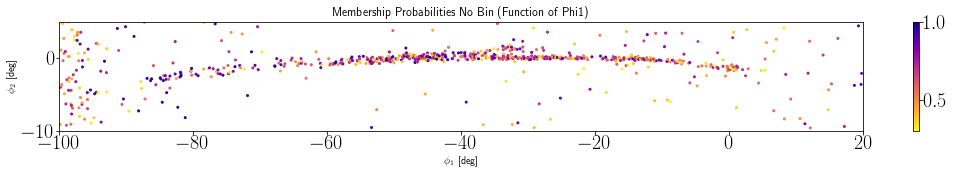

In [14]:
after1 = GaiaData('../data/member_prob_1.fits')
high_memb_prob1 = after1[after1.post_member_prob > 0.3]

plt.figure(figsize=(18,2))
plt.scatter(high_memb_prob1.phi1, high_memb_prob1.phi2, 
            c = high_memb_prob1.post_member_prob, s = 4, cmap='plasma_r', vmax=1)
plt.colorbar()
plt.xlim(-100, 20); plt.ylim(-10, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title('Membership Probabilities No Bin (Function of Phi1)')
#plt.savefig('../memb_probabilities_stream_no_bin.jpg')

(-6.0, 0.0)

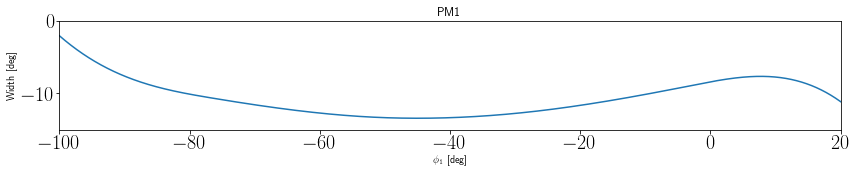

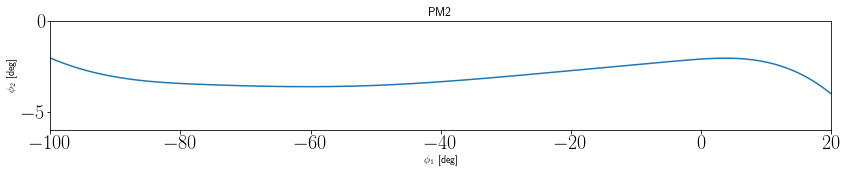

In [15]:
plt.figure(figsize = (14,2))
plt.plot(phi1_stream, res['mean_pm_stream'][:,0])
plt.title(r'PM1')
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'Width [deg]')
plt.xlim(-100, 20); plt.ylim(-15,0)

plt.figure(figsize = (14,2))
plt.plot(phi1_stream, res['mean_pm_stream'][:,1])
plt.title(r'PM2')
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.xlim(-100, 20); plt.ylim(-6,0)

## Adding a $\phi_2$ track to the model

In [21]:
with pm.Model() as model:
    n_pm_nodes, n_track_nodes, n_width_nodes = 6, 10, 5
    
    # mixture weight
    alpha = pm.Uniform('alpha', lower = 0, upper = 1, testval=5e-4)

    loglike_fg_pm = pmf.pm_model_spline(model, obs_pm, obs_pm_cov, phi1_stream, n_pm_nodes)
    ll_fg_pm = pm.Deterministic('ll_fg_pm', tt.log(alpha) + loglike_fg_pm)
    
    loglike_fg_phi2 = pmf.phi2_model_spline(model, phi1_stream, phi2_stream, n_track_nodes, n_width_nodes)
    loglike_fg_phi2 = loglike_fg_phi2.reshape(loglike_fg_pm.shape)
    ll_fg_phi2 = pm.Deterministic('ll_fg_phi2', tt.log(alpha) + loglike_fg_phi2)
    
    #total foreground likelihood
    loglike_fg = loglike_fg_pm + loglike_fg_phi2
    
    ll_fg_full = pm.Deterministic('ll_fg_full', tt.log(alpha) + loglike_fg)
    ll_bg_full = pm.Deterministic('ll_bg_full', tt.log(1 - alpha) + ln_bg_prob)

    loglike = pm.logaddexp(ll_fg_full, ll_bg_full)
    pm.Potential("loglike", loglike)

In [22]:
with model:
    res = pmx.optimize()

optimizing logp for variables: [width_nodes, track_nodes, ln_std_pm_stream, pm_nodes, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: -2612701.4556588116 -> -2612195.7274192404


398 622833
531 622833
3277 622833


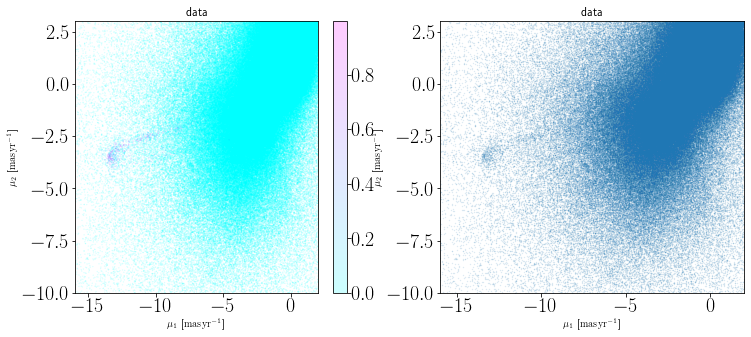

In [23]:
post_member_prob2 = np.exp(
            res['ll_fg_full'] 
            - np.logaddexp(res['ll_fg_full'], res['ll_bg_full']))

post_member_prob2_pm = np.exp(
            res['ll_fg_pm'] 
            - np.logaddexp(res['ll_fg_pm'], res['ll_bg_full']))

post_member_prob2_phi2 = np.exp(
            res['ll_fg_phi2'] 
            - np.logaddexp(res['ll_fg_phi2'], res['ll_bg_full']))

print((post_member_prob2 > 0.3).sum(), len(post_member_prob2))
print((post_member_prob2_pm > 0.3).sum(), len(post_member_prob2))
print((post_member_prob2_phi2 > 0.3).sum(), len(post_member_prob2))

pmf.plot_pm_memb_prob(obs_pm, post_member_prob2)

In [24]:
tbl = at.Table()
tbl['phi1'] = phi1_stream
tbl['phi2'] = phi2_stream
tbl['pm1'] = obs_pm[:,0]
tbl['pm2'] = obs_pm[:,1]
tbl['pm_cov'] = obs_pm_cov
tbl['ln_bg_prob'] = ln_bg_prob
tbl['post_member_prob'] = post_member_prob2
tbl['post_member_prob_pm'] = post_member_prob2_pm
tbl['post_member_prob_phi2'] = post_member_prob2_phi2


tbl.write('../data/member_prob_2.fits', overwrite=True)

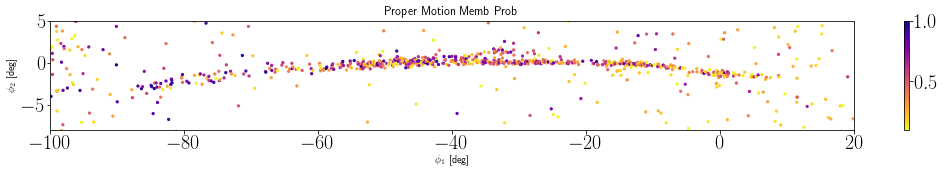

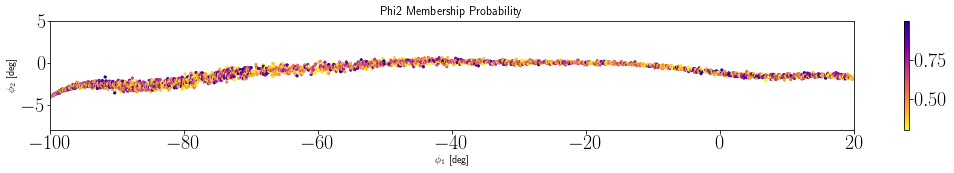

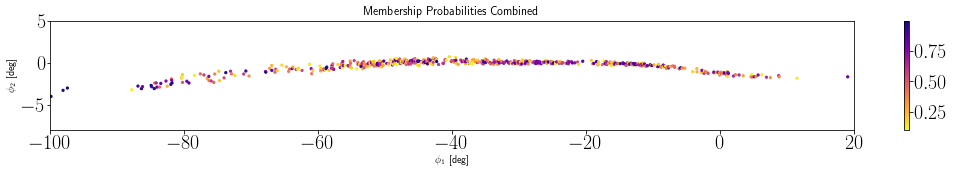

In [25]:
# QUESTION: when plotting, do we want to use just one cut on the total memb prob or do we want to say 
##           memb_prob_pm > 0.6 OR memb_prob_phi2>0.8

after2 = GaiaData('../data/member_prob_2.fits')

high_memb_prob2_pm = after2[after2.post_member_prob_pm > 0.1]
high_memb_prob2_phi2 = after2[after2.post_member_prob_phi2 > 0.3]

high_memb_prob2 = after2[after2.post_member_prob > 0.1]
high_memb_prob2_OR = after2[((after2.post_member_prob_phi2 > 0.3) | (after2.post_member_prob_pm > 0.1))
                           & (after2.post_member_prob > 0.1)]

plt.figure(figsize=(18,2))
plt.scatter(high_memb_prob2_pm.phi1, high_memb_prob2_pm.phi2, c = high_memb_prob2_pm.post_member_prob_pm,
            s = 5, cmap='plasma_r', vmax=1)
plt.colorbar()
plt.xlim(-100, 20); plt.ylim(-8, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Proper Motion Memb Prob')

plt.figure(figsize=(18,2))
plt.scatter(high_memb_prob2_phi2.phi1, high_memb_prob2_phi2.phi2, c=high_memb_prob2_phi2.post_member_prob_phi2, 
            s = 5, cmap='plasma_r')
plt.colorbar()
plt.xlim(-100, 20); plt.ylim(-8, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Phi2 Membership Probability')

plt.figure(figsize=(18,2))
plt.scatter(high_memb_prob2_OR.phi1, high_memb_prob2_OR.phi2, c = high_memb_prob2_OR.post_member_prob, 
            s = 5, cmap='plasma_r')
plt.colorbar()
plt.xlim(-100, 20); plt.ylim(-8, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Membership Probabilities Combined')
plt.savefig('../figures/memb_prob_stream_phi2_track.jpg')

(-5.0, 0.0)

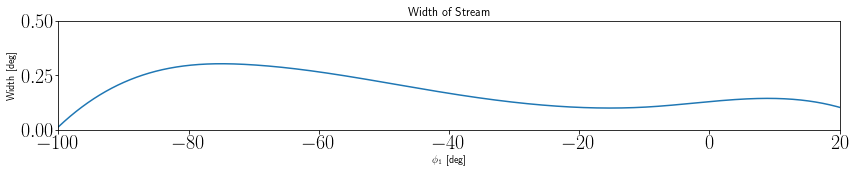

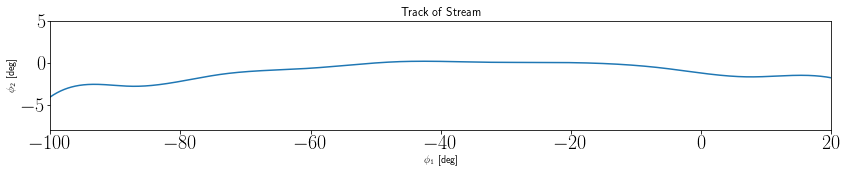

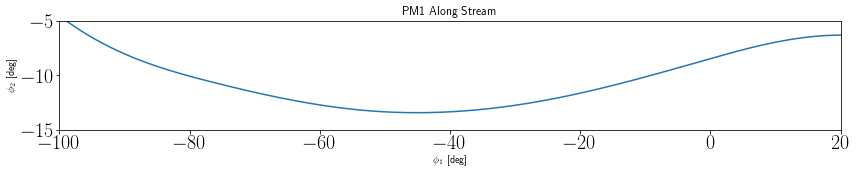

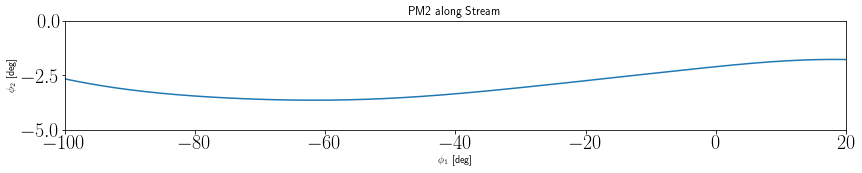

In [27]:
plt.figure(figsize = (14,2))
plt.plot(phi1_stream, res['std_phi2_stream'])
plt.title(r'Width of Stream')
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'Width [deg]')
plt.xlim(-100, 20); plt.ylim(0,0.5)

plt.figure(figsize = (14,2))
plt.plot(phi1_stream, res['mean_phi2_stream'])
plt.title(r'Track of Stream')
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.xlim(-100, 20); plt.ylim(-8,5)

plt.figure(figsize = (14,2))
plt.plot(phi1_stream, res['mean_pm_stream'][:,0])
plt.title(r'PM1 Along Stream')
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.xlim(-100, 20); plt.ylim(-15,-5)

plt.figure(figsize = (14,2))
plt.plot(phi1_stream, res['mean_pm_stream'][:,1])
plt.title(r'PM2 along Stream')
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.xlim(-100, 20); plt.ylim(-5,0)

## Check the proper motion and phi2 along the stream

           2
-0.001229 x - 0.09943 x - 2.169


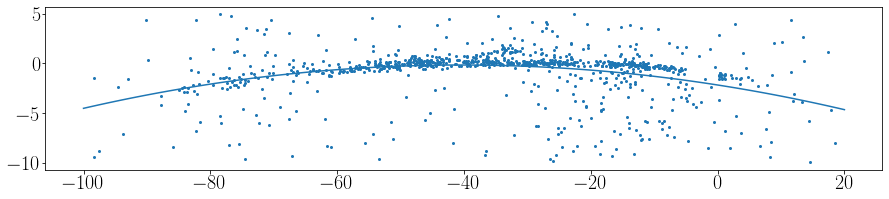

In [28]:
after = GaiaData('../data/member_prob.fits')
high_memb_prob = after[after.post_member_prob > 0.3]

xs=np.linspace(-100,20, 1000)

plt.figure(figsize=(15,3))
plt.scatter(high_memb_prob.phi1, high_memb_prob.phi2, s = 4)

ptrack = np.polyfit(high_memb_prob.phi1, high_memb_prob.phi2, 2)
polytrack = np.poly1d(ptrack)
print(polytrack)
phi1_ = np.linspace(-100, 20, 100)
phi2_ = polytrack(phi1_)
plt.plot(phi1_,phi2_)

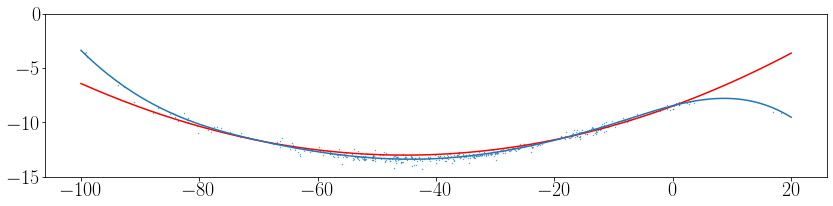

In [30]:
xs=np.linspace(-100,20, 1000)

a,b,c = 0.0022, 0.1993, -8.5121

def quad(xs):
    return a*xs**2+b*xs+c

plt.figure(figsize=(14,3))
plt.scatter(high_memb_prob2.phi1, high_memb_prob2.pm1, s = 0.1)
plt.plot(xs, quad(xs), c= 'r')
plt.ylim(-15,0)
plt.plot(phi1_stream, res['mean_pm_stream'][:,0])


(-15.0, 5.0)

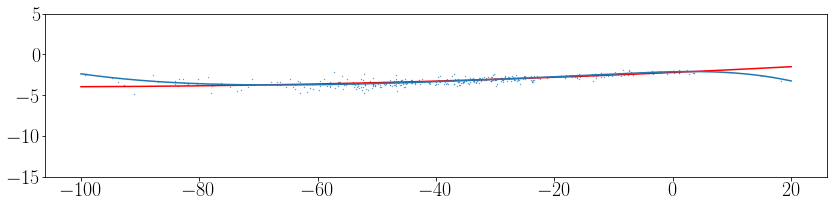

In [31]:
xs=np.linspace(-100,20, 1000)

a,b,c = 0.00015, 0.03246, -2.23172

def quad(xs):
    return a*xs**2+b*xs+c

plt.figure(figsize=(14,3))
plt.scatter(high_memb_prob2.phi1, high_memb_prob2.pm2, s = 0.1)
plt.plot(xs, quad(xs), c= 'r')
plt.plot(phi1_stream, res['mean_pm_stream'][:,1])
plt.ylim(-15,5)

# Discontinuity at $\phi_1 \approx -75$ (progenitor?, probably not)

Thought: if this is in fact the progenitor, then we would probably have to redo the phi2 track fit for this region since the track changes. This might also help the track align with some BHB and BS that were found in 2018 near $\phi_1 = -95$

Text(0.5, 1.0, 'Progenitor(?) Region')

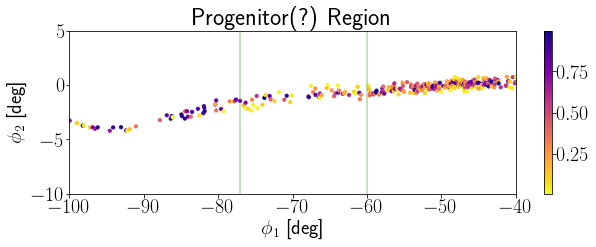

In [78]:
plt.figure(figsize=(10,3))
plt.scatter(high_memb_prob3_OR.phi1, high_memb_prob3_OR.phi2, c = high_memb_prob3_OR.post_member_prob, 
            s = 10, cmap='plasma_r')
plt.colorbar()
plt.xlim(-100, -40); plt.ylim(-10, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.plot([-77, -77], [-10,5], c = 'green', alpha=0.3)
plt.plot([-60, -60], [-10,5], c = 'green', alpha=0.3)
plt.title(r'Progenitor(?) Region')

           3             2
6.912e-06 x - 0.0007689 x - 0.1336 x - 4.293
           3            2
3.102e-06 x - 0.000736 x - 0.06406 x - 1.024


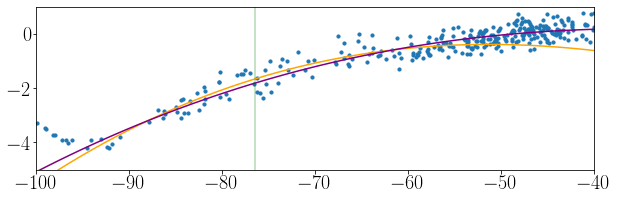

In [85]:
# fitting quadratics to the two parts of the stream just to see
plt.figure(figsize=(10,3))
plt.scatter(high_memb_prob3_OR.phi1, high_memb_prob3_OR.phi2, s = 10)

ptrack = np.polyfit(high_memb_prob3_OR.phi1[(high_memb_prob3_OR.phi1 < -55) & (high_memb_prob3_OR.phi1 > -95)], 
                    high_memb_prob3_OR.phi2[(high_memb_prob3_OR.phi1 < -55) & (high_memb_prob3_OR.phi1 > -95)],
                    deg = 3)
polytrack = np.poly1d(ptrack)
print(polytrack)
phi1_1 = np.linspace(-100, 20, 100)
phi2_1 = polytrack(phi1_1)
plt.plot(phi1_1,phi2_1, c = 'orange')


ptrack = np.polyfit(high_memb_prob3_OR.phi1[high_memb_prob3_OR.phi1 > -76.5], 
                    high_memb_prob3_OR.phi2[high_memb_prob3_OR.phi1 > -76.5], deg = 3)
polytrack = np.poly1d(ptrack)
print(polytrack)
phi1_2 = np.linspace(-100, 20, 100)
phi2_2 = polytrack(phi1_2)
plt.plot(phi1_2,phi2_2, c = 'purple')

plt.plot([-76.5, -76.5], [-10,5], c = 'green', alpha=0.3)

plt.xlim(-100, -40); plt.ylim(-5, 1); 

### Next:

1. Look into AAU and how long ago we think that disconituity may have formed.
2. Look into Pal 5 progenitor information, since this would be a similar shape for the stream. 
3. Look into surveys in that region of the sky